Aim of the note is to explore what should be done with the sensor depths from the closeup dataset.

In [1]:
%matplotlib inline
import numpy as np
from archs.VGGNet import Feat2d
import matplotlib.pyplot as plt

In [53]:
net = Feat2d(touch_emb_dim=32)

In [2]:
datapath = "/home/gauravp/new_closeup_dataset/cups/6e884701bfddd1f71e1138649f4c219/touch_data.npy"

In [3]:
all_data = np.load(datapath, allow_pickle=True).item()

In [4]:
all_data.keys()

dict_keys(['sensor_imgs', 'sensor_depths', 'sensor_intrinsics', 'sensor_extrinsics', 'camR_T_origin'])

In [5]:
sensor_depths = all_data.sensor_depths
sensor_imgs = all_data.sensor_imgs

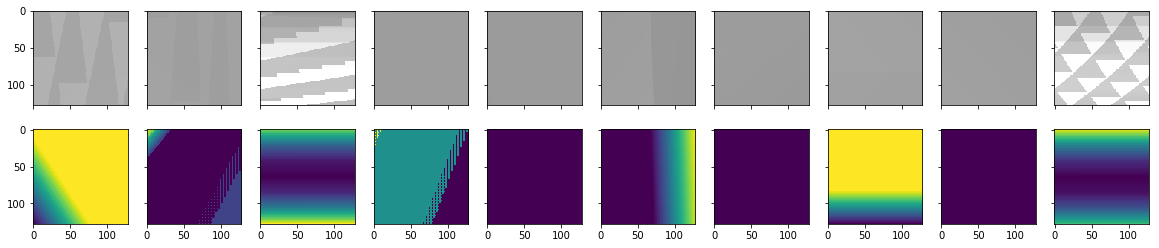

In [6]:
# now plot a few of those meaning hundred to check how they look
fig_size = 2 * np.asarray([10, 2])
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=fig_size, sharex=True, sharey=True)

idxs = np.random.permutation(len(sensor_depths))
chosen_depths = sensor_depths[idxs[:10]]
chosen_imgs = sensor_imgs[idxs[:10]]
for i in range(len(chosen_depths)):
    axes[0, i].imshow(chosen_imgs[i])
    axes[1, i].imshow(chosen_depths[i])

(array([ 9600.,  3840., 18560.,  1024., 16128., 32768., 66987.,  6850.,
         5599.,  2484.]),
 array([0.06634322, 0.06685515, 0.06736708, 0.06787901, 0.06839095,
        0.06890288, 0.06941481, 0.06992675, 0.07043868, 0.07095061,
        0.07146254], dtype=float32),
 <a list of 10 Patch objects>)

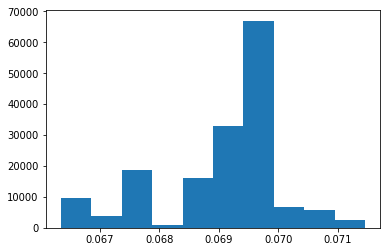

In [8]:
# plot the histogram of depths for these chosen one since they are all very close they histogram should be very close to zero
plt.hist(chosen_depths.flatten())

In [26]:
# okay now lets clip the depth between (0 and 1) and see if the histogram changes in value
clipped_depths = np.clip(chosen_depths, 0, 10)
print(clipped_depths.max())
print(clipped_depths.min())
print(clipped_depths.shape)

0.07146254
0.06634322
(10, 128, 128)


(array([ 9600.,  3840., 18560.,  1024., 16128., 32768., 66987.,  6850.,
         5599.,  2484.]),
 array([0.06634322, 0.06685515, 0.06736708, 0.06787901, 0.06839095,
        0.06890288, 0.06941481, 0.06992675, 0.07043868, 0.07095061,
        0.07146254], dtype=float32),
 <a list of 10 Patch objects>)

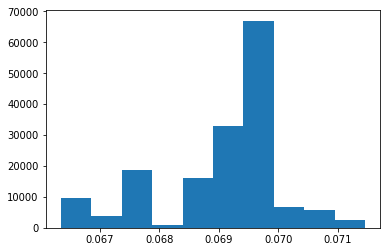

In [10]:
plt.hist(clipped_depths.flatten())

In [20]:
# Adam suggested to rescale the depth images to size 16x16 I will do it and see the effect on the depth values and images
import skimage.transform
my_resize = lambda img: skimage.transform.resize(img, (16, 16), anti_aliasing=True)

In [21]:
resized_chosen_depths = np.stack(list(map(my_resize, chosen_depths)))
print(resized_chosen_depths.shape)

(10, 16, 16)


## Resize Observations
1. The images look the same but are more raggedy along the edges, did I not set antialiasing as true

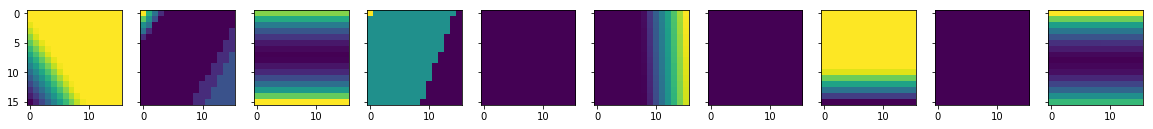

In [22]:
# visualize the images first and then check its histogram
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=fig_size, sharex=True, sharey=True)
for i in range(len(resized_chosen_depths)):
    axes[i].imshow(resized_chosen_depths[i])

(array([144.,  64., 288.,  16., 256., 256., 998., 377.,  81.,  80.]),
 array([0.06636067, 0.06684462, 0.06732857, 0.06781253, 0.06829648,
        0.06878044, 0.06926439, 0.06974834, 0.0702323 , 0.07071625,
        0.07120021], dtype=float32),
 <a list of 10 Patch objects>)

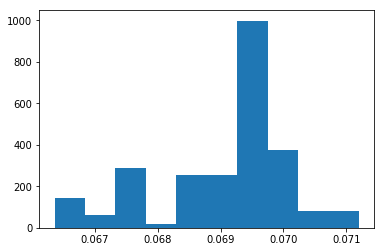

In [27]:
#plot the histogram too to check the values are not changed drastically
# ofcourse the numbers are less since you have resized the images. But the data dist has not changed
# drastically so it is a good sign?
plt.hist(resized_chosen_depths.flatten())

In [62]:
# how to pass them through the VGG net
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import torch

## Strategy 1:
Trying to pass all of them together in one whole batch

In [63]:
net = net.cuda()

In [64]:
torch_sensor_depths = np.expand_dims(sensor_depths, 1)
torch_sensor_depths = torch.from_numpy(torch_sensor_depths).float()

In [65]:
# now I will keep the batch size of 1024 and try to do the forward pass
sampler = BatchSampler(
            SubsetRandomSampler(range(len(torch_sensor_depths))),
            1024,
            drop_last=False)

In [67]:
%timeit
outputs = torch.zeros(len(sensor_depths), 32)
for idxs in sampler:
    c_depths = torch_sensor_depths[idxs]
    outputs[idxs] = net(c_depths.cuda())

RuntimeError: CUDA out of memory. Tried to allocate 4.00 GiB (GPU 0; 11.91 GiB total capacity; 8.26 GiB already allocated; 2.82 GiB free; 216.44 MiB cached)